In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math,logging
import os,sys
parentdir = os.path.dirname(os.path.abspath('.'))
temp_path = os.path.join(parentdir,'JY_Toolkit')
sys.path.insert(0,temp_path)
# from JY_Toolkit import Jy_makeDataset,Jy_dataSetProcess
import JY_Toolkit
from JY_Toolkit import Jy_dataShow

random_seed = 5225
np.random.seed(random_seed)

logging.basicConfig(level=logging.INFO)
logging.info(f'logging info normal , success')

INFO:root:logging info normal , success


## 构筑双月数据集用以实验

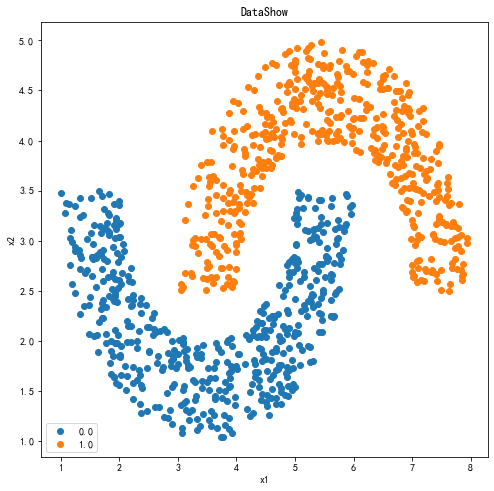

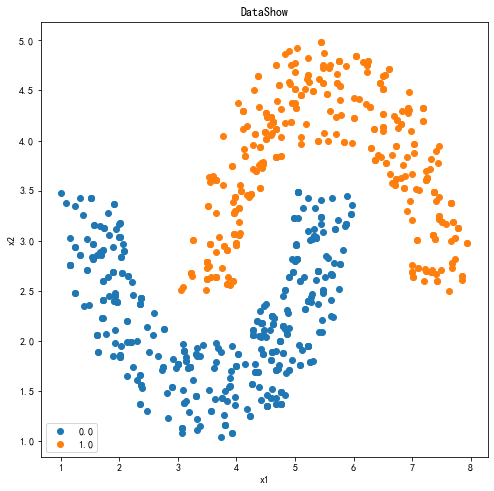

(array([1.61104961, 2.06135722]), 0.0)

In [18]:
JY_Toolkit.Jy_makeDataset.random_state(random_seed)
X,y = JY_Toolkit.Jy_makeDataset.draw_HalfMoon(n_sample=1000,slope= 0,radius=2,hor_distance=2,ver_distance=-1,positive_val=1,negative_val=0)
Jy_dataShow.show_TwoDimData(X,y)
X_train,X_test,y_train,y_test = JY_Toolkit.Jy_dataSetProcess.Jy_train_test_split(X,y)
Jy_dataShow.show_TwoDimData(X_train,y_train)

X_train[0],y_train[0]

In [19]:
class MLP(object):
    def __init__(self,
                 structure: tuple,
                 *,
                 activate='sigmoid'):
        self.layers = structure
        self.num_layers = len(structure)
        self.structure = structure
        self.weights = [np.random.randn(n, m+1)
                        for n, m in zip(structure[1:], structure[:-1])]
        # self.weights = [np.ones((n, m+1),dtype=np.float64) + 1
        #                 for n, m in zip(structure[1:], structure[:-1])]
        self.loss_rate = []  # 错误率
        self.epsilon = []     # 误差
        if activate == 'sigmoid':
            self.ac = MLP.sigmoid
            self.ac_Derivative_1 = MLP.sigmoid_Derivative_1
        if activate == 'relu':
            self.ac = MLP.Relu
            self.ac_Derivative_1 = MLP.Relu_Derivative_1

        pass
    # 激活函数

    def sigmoid(z):
        ans = 1.0/(1.0 + np.exp(-z))
        return ans

    def sigmoid_Derivative_1(z):
        # sigmoid 函数的一阶导数
        return MLP.sigmoid(z) * (1 - MLP.sigmoid(z))

    def Relu(z):
        # return max(0, z)
        # return np.max(0,z)
        mask = z < 0
        z[mask] = 0
        return z

    def Relu_Derivative_1(z):
        # if z >= 0:
        #     return 1
        # else:
        #     return 0
        mask = z >= 0
        z[mask] = 1
        mask = z < 0
        z[mask] = 0
        return z
    # 前向传播

    def single_feed_forwaed(self, x):
        # 对单个样本的前向传播
        temp_value = x
        # 对每一层的遍历
        for i in range(len(self.weights)):
            # 打印 增广前的输出
            temp_value = np.r_[temp_value, 1]
            # 打印 增广后的输出
            temp_value = self.ac(
                np.dot(self.weights[i], temp_value))
        y = temp_value
        return y

    def backprop(self, x, y):
        # x,y 输入单个样本数据和其期望输出
        delta_w = [np.zeros(w.shape) for w in self.weights]
        v = []  # 诱导局部域
        temp = x
        z = [temp]  # 激活函数输出，节点的输出,以及输入层的输入
        # 前向传播，存储下各层的诱导局部域以及各节点的输出
        for w in self.weights:
            temp = np.r_[temp, 1]
            # 计算诱导局部域
            # print(f'temp : {temp} {temp.shape} , w : {w} {w.shape}')
            temp = np.dot(w, temp)
            # print(f' res temp : {temp}')
            v.append(temp)
            # 经过激活函数，计算节点输出
            temp = self.ac(temp)
            z.append(temp)
        # print(f'v {v} \n z{z}')

        # 计算输出层的局部梯度 \delta
        e = y - z[-1]
        local_delta = e * self.ac_Derivative_1(v[-1])
        # z[-1] 是网络的最终输出，我们需要取输出层的输入，所以应该取z[-2], 因为要考虑到偏执项，故增广1列
        delta_w[-1] = np.dot(local_delta, np.r_[z[-2], 1].reshape(
            self.weights[-1].shape)).reshape(self.weights[-1].shape)
        # 计算每一层的 Delta
        for i in range(2, self.num_layers):
            local_delta = self.ac_Derivative_1(
                v[-i]) * np.dot(local_delta, self.weights[-i+1][:, :-1])
            delta_w[-i] = np.dot(local_delta.reshape(len(local_delta), 1),
                                 np.r_[z[-i-1], 1].reshape(1, len(np.r_[z[-i-1], 1])))
        return delta_w

    def update_mini_batch(self, batch_X, batch_y, learning_rate, batch_size):
        # 定义一个总的 Delta w 和，将batch内每个样本的 delta累加起来
        all_delta_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in zip(batch_X, batch_y):
            delta_w = self.backprop(x, y)
            all_delta_w = [a+b for a, b in zip(all_delta_w, delta_w)]
        self.weights = [w + (learning_rate/batch_size) *
                        Delta for w, Delta in zip(self.weights, all_delta_w)]

    def fit(self, X_train, y_train,
            *,
            epochs=10,
            batch_size=1,
            learning_rate=0.001,
            tol_enable=True,
            tol=1e-5,
            tol_size=50):
        self.loss_rate.clear()
        for _iter in range(epochs):
            X = [X_train[k:k+batch_size]
                 for k in range(0, len(X_train), batch_size)]
            y = [y_train[k:k+batch_size]
                 for k in range(0, len(y_train), batch_size)]
            for batch_X, batch_y in zip(X, y):
                self.update_mini_batch(
                    batch_X, batch_y, learning_rate, batch_size)
            accuracy,epsilon = self.score(X_train, y_train)
            self.epsilon.append(epsilon)
            accuracy_rate = 100*accuracy/len(X_train)
            _iter_loss_rate = (1 - accuracy/len(X_train))*100
            self.loss_rate.append(_iter_loss_rate)
            print(
                f"Structure : {self.structure} , max_epoch : {epochs} , _iter:{_iter} , accuracy : {accuracy},accracy_rate = {100*accuracy/len(X_train)}% , epsilon : {epsilon}")
            # if tol_enable == True and _iter > tol_size and abs(epsilon - self.epsilon[-tol_size - 1]) <= tol:
            if tol_enable == True and _iter > tol_size and np.std(self.epsilon[-tol_size-1:]) <= tol:
                print(f'Converge to {accuracy_rate} ,epsilon : {self.epsilon[-tol_size-1:]} , tol_std:{np.std(self.epsilon[-tol_size-1:])}')
                return

    def predict_single(self, x):
        res = self.single_feed_forwaed(x)
        if self.ac == MLP.sigmoid:
            if res >= 0.5:
                return 1
            else:
                return 0
        elif self.ac == MLP.Relu:
            if res > 0:
                return 1
            else:
                return 0

    def score(self, X, y):
        accuracy_count = 0
        all_epsilon = 0
        for features, expect_label in zip(X, y):
            predict_label = self.predict_single(features)
            all_epsilon += 0.5*(expect_label - self.single_feed_forwaed(features))**2
            if predict_label == expect_label:
                accuracy_count += 1
        return accuracy_count,all_epsilon/len(X)
    pass


# mlp = MLP((2,4,1))
# print(X_train[0])
# mlp.backprop(X_train[0], y_train[0])


## 开始训练

In [20]:
# test
# layer = [[2,20,1],[2, 100,100, 1],[2,100,200,100,1]]
# layer = [[2,20,1],[2, 100, 1],[2,200,1],[2,20,20,1]]
# layer = [[2,100,100,1]]
layer = [[2,20,1]]
mistake_line = []
epsilon_line = []
# mlp = MLP((2, 100,100, 1))
mlp_arr = []
for i in range(len(layer)):
    mlp = MLP(layer[i],activate='sigmoid')
    mlp_arr.append(mlp)
    mlp.fit(X_train, y_train,batch_size= 1,epochs=600,learning_rate=0.1,tol_size=5,tol=1e-6)
    # mlp.score(X_test, y_test)/len(X_test)
    mistake_line.append(mlp.loss_rate)
    epsilon_line.append(mlp.epsilon)


Structure : [2, 20, 1] , max_epoch : 600 , _iter:0 , accuracy : 648,accracy_rate = 81.0% , epsilon : [0.07931]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:1 , accuracy : 674,accracy_rate = 84.25% , epsilon : [0.06405756]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:2 , accuracy : 681,accracy_rate = 85.125% , epsilon : [0.05504371]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:3 , accuracy : 683,accracy_rate = 85.375% , epsilon : [0.04933081]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:4 , accuracy : 689,accracy_rate = 86.125% , epsilon : [0.04545526]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:5 , accuracy : 691,accracy_rate = 86.375% , epsilon : [0.04265939]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:6 , accuracy : 696,accracy_rate = 87.0% , epsilon : [0.04051513]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:7 , accuracy : 705,accracy_rate = 88.125% , epsilon : [0.03876869]
Structure : [2, 20, 1] , max_epoch : 600 , _iter:8 , accuracy : 721,accracy_rate

In [21]:
for i in mistake_line:
    print(f'{100 -i[-1]}%')

for i in epsilon_line:
    print(i[-1])

99.625%
[0.00209655]


## 分析 [2,20,1] 网络

Text(0.5, 1.0, '平均误差能量曲线')

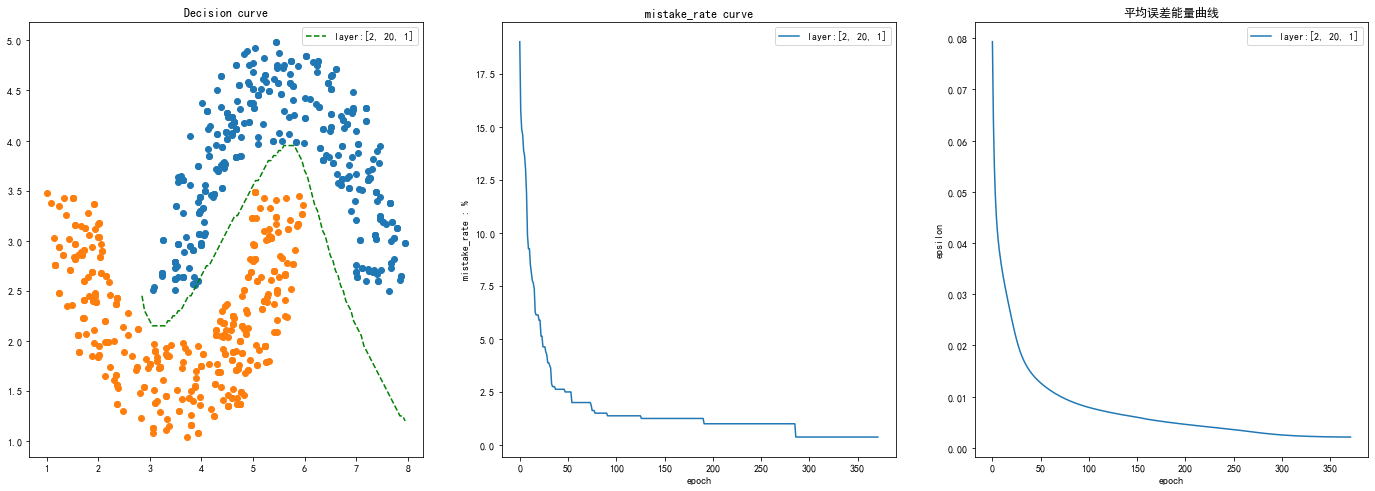

In [22]:
plt.rcParams["font.family"]="SimHei"
p_point_x1 = [ X_train[i,0] for i in range(len(X_train)) if y_train[i] == 1]
p_point_x2 = [ X_train[i,1] for i in range(len(X_train)) if y_train[i] == 1]
n_point_x1 = [ X_train[i,0] for i in range(len(X_train)) if y_train[i] == 0]
n_point_x2 = [ X_train[i,1] for i in range(len(X_train)) if y_train[i] == 0]

fig = plt.figure(figsize=(24,8))
ax_1 = fig.add_subplot(131)
ax_2 = fig.add_subplot(132)
ax_3 = fig.add_subplot(133)

ax_1.scatter(p_point_x1, p_point_x2, alpha=1)
ax_1.scatter(n_point_x1, n_point_x2, alpha=1)

test_x = []
test_y = []
y_p_old = 0
for x in np.arange(1., 8., 0.05):  # 取点x=-15~25  y=-10~10 带入前向计算 得出y_p
    y_p_old = None
    for y in np.arange(0., 5., 0.05):
        y_p = mlp_arr[0].predict_single((x,y))
        # print(y_p)
        # 如果上次y_p小于0.5 并且 这次y_p大于0.5，
        if y_p_old != None and y_p_old != y_p:
            if x not in test_x:
                test_x.append(x)  # 在列表末尾追加新的对象x
            # if y not in test_y:
                test_y.append(y-0.05)  # 在列表末尾追加新的对象y
        y_p_old = y_p
ax_1.plot(test_x,test_y,'g--',label=f'layer:{layer[0]}')
# ax_1.scatter(test_x,test_y,label=f'layer:{layer[0]}')

ax_2.set_xlabel('epoch')
ax_2.set_ylabel('mistake_rate : %')
ax_2.plot(range(len(mistake_line[0])),mistake_line[0],label=f'layer:{layer[0]}')

ax_3.set_xlabel('epoch')
ax_3.set_ylabel('epsilon')
ax_3.plot(range(len(epsilon_line[0])),epsilon_line[0],label=f'layer:{layer[0]}')

ax_1.legend(loc=1)
ax_2.legend(loc=1)
ax_3.legend(loc=1)

ax_1.set_title('Decision curve')
ax_2.set_title('mistake_rate curve')
# ax_3.set_title('ϵ curve')
ax_3.set_title('平均误差能量曲线')



In [23]:
for i in range(len(layer)):
    count,epsilon = mlp_arr[i].score(X_test, y_test)
    print(len(X_test),count,count/len(X_test) * 100,'%',epsilon)
    print(f'last _iter :{len(epsilon_line[i])}')
# 0.0000531
# 0.00024

199 199 100.0 % [0.00052576]
last _iter :372


### 绘制分割曲线以及训练过程中的错误率曲线

<class 'numpy.ndarray'> (800, 2)


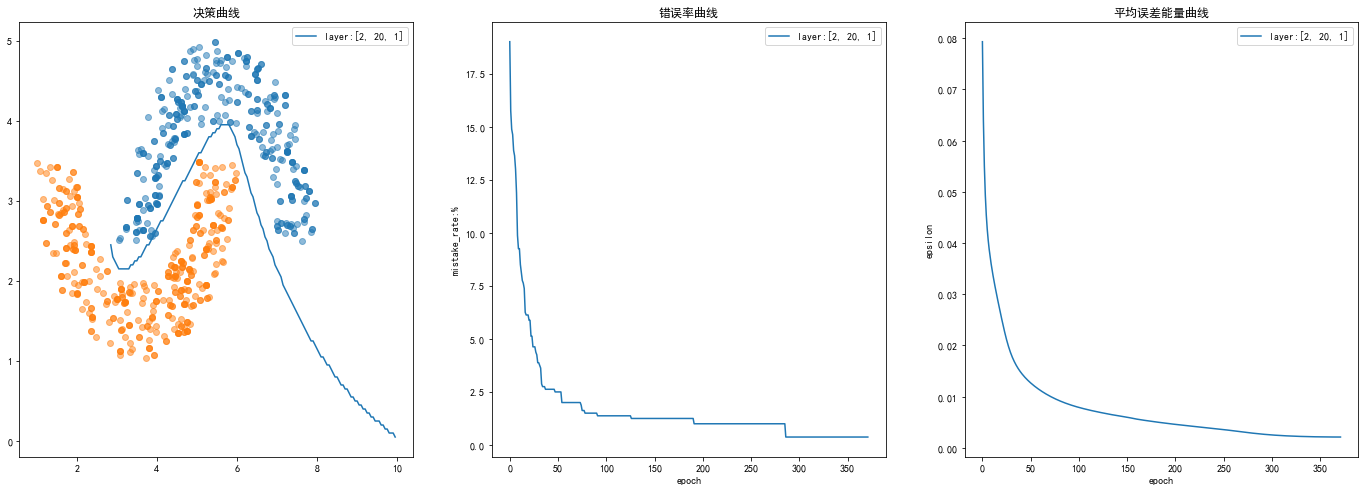

In [24]:
line_p_x = []
line_p_y = []

print(type(X_train) , X_train.shape)

p_point_x1 = [ X_train[i,0] for i in range(len(X_train)) if y_train[i] == 1]
p_point_x2 = [ X_train[i,1] for i in range(len(X_train)) if y_train[i] == 1]
n_point_x1 = [ X_train[i,0] for i in range(len(X_train)) if y_train[i] == 0]
n_point_x2 = [ X_train[i,1] for i in range(len(X_train)) if y_train[i] == 0]

fig = plt.figure(num=1,figsize = (24,8))
ax_1 = fig.add_subplot(131)
ax_2 = fig.add_subplot(132)
ax_1.scatter(p_point_x1, p_point_x2, alpha=0.5)
ax_1.scatter(n_point_x1, n_point_x2, alpha=0.5)


''' cankao'''
line_x = []
line_y = []
for i in range(len(layer)):
    test_x = []
    test_y = []
    for x in np.arange(1., 10., 0.05):  # 取点x=-15~25  y=-10~10 带入前向计算 得出y_p
        y_p_old = None
        for y in np.arange(0., 5., 0.05):
            y_p = mlp_arr[i].predict_single((x,y))
            # print(y_p)
            # 如果上次y_p小于0.5 并且 这次y_p大于0.5，
            if y_p_old != None and y_p_old != y_p:
                if x not in test_x:
                    test_x.append(x)  # 在列表末尾追加新的对象x
                    test_y.append(y - 0.05)  # 在列表末尾追加新的对象y
            y_p_old = y_p
# 画决策边界
    line_x.append(test_x)
    line_y.append(test_y)
for i in range(len(layer)):
    # ax_1.scatter(line_x[i], line_y[i],s = 3,label=f'layer:{layer[i]}')
    ax_1.plot(line_x[i], line_y[i],label=f'layer:{layer[i]}')
ax_1.legend(loc=1)
''' s '''

ax_2.set_xlabel('epoch')
ax_2.set_ylabel('mistake_rate:%')

for i in range(len(layer)):
    ax_2.plot(range(len(mistake_line[i])),mistake_line[i],label=f'layer:{layer[i]}')
ax_2.legend(loc = 1)

ax_3 = fig.add_subplot(133)
ax_3.set_xlabel('epoch')
ax_3.set_ylabel('epsilon')

for i in range(len(layer)):
    ax_3.plot(range(len(epsilon_line[i])),epsilon_line[i],label=f'layer:{layer[i]}')
ax_3.legend(loc = 1)

ax_1.set_title('决策曲线')
ax_2.set_title('错误率曲线')
# ax_3.set_title('ϵ curve')
ax_3.set_title('平均误差能量曲线')

plt.show()

## 将刚完成的MLP与 sklearn 包中的 mlp算法进行比较

为保证可比较性，不更改数据集，仍然采用刚刚的双月数据集


In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
# layer_sklearn = [[20,],[100,100],[100,300,100,]]
layer_sklearn = [[100,100]]
mlp_sklearn = []

# for i in range(len(layer_sklearn)):
#     clf = MLPClassifier(solver='sgd',                   # 梯度下降采用SGD 随机梯度下降
#                         learning_rate='constant',       # 固定学习率的训练方式
#                         learning_rate_init=0.01,      # 初始化学习率为 0.0005 ，与上边保持一致
#                         tol= 1e-15,                      # 损失率收敛判定，即连续两次迭代，损失率或者准确率差小于 tol 则中值训练
#                         hidden_layer_sizes=layer_sklearn[i],       # 隐藏层定义
#                         random_state=random_seed,       # 随机数种子，方便复现
#                         activation='logistic',          # 激活函数采用 sigmoid 函数 即 logistic函数
#                         max_iter=1000,                   # 最大迭代次数
#                         )                  
#     mlp_sklearn.append(clf)
#     clf.fit(X_train, y_train)
for i in range(len(layer_sklearn)):
    clf = MLPRegressor(solver='sgd',                   # 梯度下降采用SGD 随机梯度下降
                        learning_rate='constant',       # 固定学习率的训练方式
                        learning_rate_init=0.01,      # 初始化学习率为 0.0005 ，与上边保持一致
                        tol= 1e-15,                      # 损失率收敛判定，即连续两次迭代，损失率或者准确率差小于 tol 则中值训练
                        hidden_layer_sizes=layer_sklearn[i],       # 隐藏层定义
                        random_state=random_seed,       # 随机数种子，方便复现
                        activation='logistic',          # 激活函数采用 sigmoid 函数 即 logistic函数
                        max_iter=1000,                   # 最大迭代次数
                        )                  
    mlp_sklearn.append(clf)
    clf.fit(X_train, y_train)


layer:[100, 100],test_loss :  0.0 % 0.0 %
0.04657803859490658


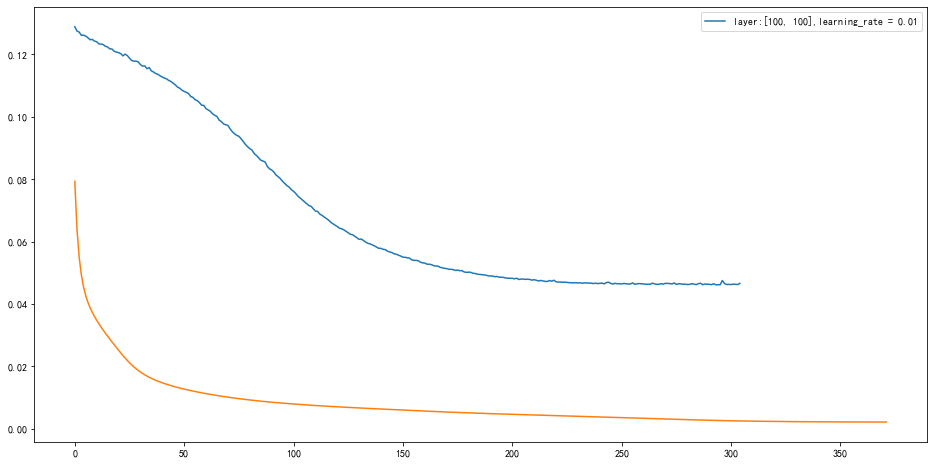

In [34]:
def sklearn_mlp_score(X_test,y_test,clf):
    predict = clf.predict(X_test)
    accuracy_count = 0
    for pre , expect in zip(predict,y_test):
        if pre == expect:
            accuracy_count += 1
    return accuracy_count/len(y_test)


fig = plt.figure(num=1,figsize=(16,8))

ax_1 = fig.add_subplot(111)


for i in range(len(layer_sklearn)):
    ax_1.plot(range(len(mlp_sklearn[i].loss_curve_)),mlp_sklearn[i].loss_curve_,label=f'layer:{layer_sklearn[i]},learning_rate = {0.01}')
    # print(f'layer:{layer_sklearn[i]} train loss :{mlp_sklearn[i].loss_ * 100}%')
    print(f'layer:{layer_sklearn[i]},test_loss : ',sklearn_mlp_score(X_test,y_test,mlp_sklearn[i])*100,'%',sklearn_mlp_score(X_train,y_train,mlp_sklearn[i])*100,'%')
ax_1.plot(range(len(epsilon_line[0])),epsilon_line[0])
ax_1.legend(loc=1)

for i in mlp_sklearn:
    print(i.loss_)
